## Data Cleaning and Manipulation

We have already a good overview of data model after performing data exploration. Now we can start cleaning the data and doing manipulations and or aggregations.

### Functional design mockup

add later

#### _Imports_

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

### Join Table Orders & Table Visits to obtain Sales Generation Model KPIs

In our dashboard we want to show Sales Generation Model KPIs. To make this happen we need to combine metrics from two tables: Orders and Visits. As initial step we need to aggregate both tables by StoreID and Date.

Step 1: aggregation

In [3]:
orders = pd.read_csv('../data/Orders_Table.csv')
orders.head()

,OrderID,StoreID,Date,ProductID,CustomerID,PromotionID,CampaignID,OrderValue,DiscountValue
0,Order1,Store4,2021-10-18,Product473,Customer1789,Promo4,Campaign3,237.71,114.56
1,Order2,Store8,2023-08-02,Product1,Customer4648,Promo1,Campaign6,761.24,94.64
2,Order3,Store7,2022-01-06,Product416,Customer8822,Promo2,Campaign1,733.01,192.46
3,Order4,Store8,2022-06-14,Product469,Customer7305,Promo4,Campaign10,840.82,180.34
4,Order5,Store1,2022-11-23,Product365,Customer559,Promo3,Campaign3,933.60,159.52


In [24]:
orders_by_store_day = orders.groupby(['StoreID', 'Date']).agg(
    OrderValue_sum=('OrderValue', 'sum'),
    OrderID_count=('OrderID', 'count')).reset_index()
orders_by_store_day

,StoreID,Date,OrderValue_sum,OrderID_count
0,Store1,2021-01-04,195.42,1
1,Store1,2021-01-06,1725.09,2
2,Store1,2021-01-08,131.15,1
3,Store1,2021-01-18,634.59,1
4,Store1,2021-01-20,528.02,1
...,...,...,...,...
1790,Store8,2023-12-20,557.95,1
1791,Store8,2023-12-21,32.44,1
1792,Store8,2023-12-22,1046.07,2
1793,Store8,2023-12-26,321.82,1


Lets do a quick check of the result:

In [25]:
sum_orderval = orders[(orders['StoreID'] == "Store1") & (orders['Date'] == "2021-01-04")]
sum_orderval

,OrderID,StoreID,Date,ProductID,CustomerID,PromotionID,CampaignID,OrderValue,DiscountValue
1775,Order1776,Store1,2021-01-04,Product5,Customer8089,Promo4,Campaign9,195.42,132.5


For this combination of store and date we get OrderValue of 195.42, same as in the aggregated dataframe.

Additionally, lets see how much is the Order Value per year:

In [32]:
orders_by_store_day['Date'] = pd.to_datetime(orders_by_store_day['Date'])

orders_by_store_day['Year'] = orders_by_store_day['Date'].dt.year

orders_by_store_year = orders_by_store_day.groupby(['Year']).agg(OrderValue_sum=('OrderValue_sum', 'sum')).reset_index()

orders_by_store_year

,Year,OrderValue_sum
0,2021,330106.35
1,2022,330920.01
2,2023,358192.52


In [6]:
visits = pd.read_csv('../data/Visits_Table.csv')
visits.head()

,VisitID,StoreID,Date,VisitCount,CampaignID
0,Visit1,Store4,2023-11-20,456,Campaign10
1,Visit2,Store5,2023-06-06,120,Campaign3
2,Visit3,Store4,2022-01-23,332,Campaign8
3,Visit4,Store4,2022-11-11,440,Campaign5
4,Visit5,Store3,2022-04-25,427,Campaign2


In [7]:
visits_by_store_day = visits.groupby(['StoreID', 'Date']).agg(
    VisitCount_sum=('VisitCount', 'sum')).reset_index()
visits_by_store_day

,StoreID,Date,VisitCount_sum
0,Store1,2021-01-07,179
1,Store1,2021-01-16,233
2,Store1,2021-02-02,245
3,Store1,2021-02-21,449
4,Store1,2021-03-05,287
...,...,...,...
947,Store8,2023-11-18,223
948,Store8,2023-11-20,297
949,Store8,2023-11-24,438
950,Store8,2023-12-18,432


Quick check:

In [8]:
sum_visitscount = visits[(visits['StoreID'] == "Store1") & (visits['Date'] == "2021-01-07")]
sum_visitscount

,VisitID,StoreID,Date,VisitCount,CampaignID
370,Visit371,Store1,2021-01-07,179,Campaign9


Step2: join

Let's do first outer join and evaluate how many nulls we have. Just to get a filling on data quality.

In [9]:
sgm = pd.merge(orders_by_store_day, visits_by_store_day, on=['StoreID', 'Date'], how='outer')
sgm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StoreID         2540 non-null   object 
 1   Date            2540 non-null   object 
 2   OrderValue_sum  1795 non-null   float64
 3   OrderID_count   1795 non-null   float64
 4   VisitCount_sum  952 non-null    float64
dtypes: float64(3), object(2)
memory usage: 99.3+ KB


As we could imagine, there are many nulls so we cannot use this data for visualization. Therefore we will perform inner join, even so we will get much less data. The objecive of this project is to build a dashboard, the size of dataset is not important.

In [10]:
sgm = pd.merge(orders_by_store_day, visits_by_store_day, on=['StoreID', 'Date'])
sgm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StoreID         207 non-null    object 
 1   Date            207 non-null    object 
 2   OrderValue_sum  207 non-null    float64
 3   OrderID_count   207 non-null    int64  
 4   VisitCount_sum  207 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 8.2+ KB


In [11]:
sgm

,StoreID,Date,OrderValue_sum,OrderID_count,VisitCount_sum
0,Store1,2021-04-04,238.05,1,464
1,Store1,2021-09-16,509.16,1,275
2,Store1,2021-09-18,747.42,1,237
3,Store1,2021-09-25,875.08,1,120
4,Store1,2022-01-04,264.00,1,326
...,...,...,...,...,...
202,Store8,2023-08-03,86.01,1,190
203,Store8,2023-10-25,908.82,1,478
204,Store8,2023-11-11,839.34,1,416
205,Store8,2023-11-24,835.56,1,438


Lets see how the data looks like:

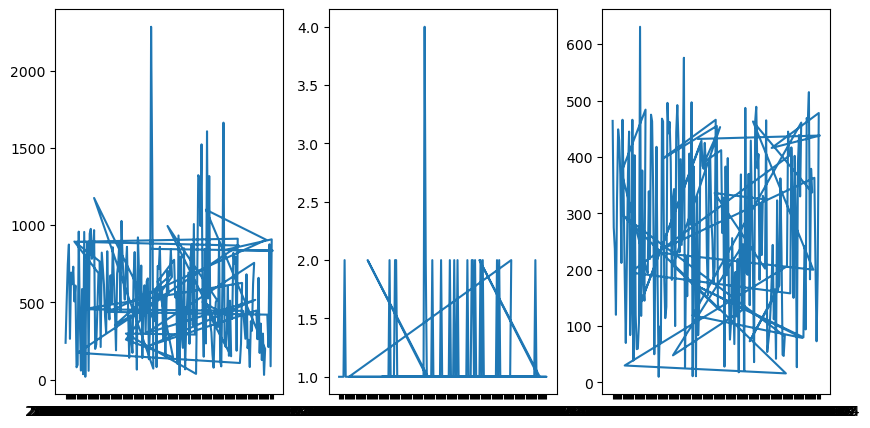

In [12]:
fig, axs = plt.subplots(ncols = 3,
                       nrows = 1, figsize = (10, 5))
axs[0].plot(sgm['Date'], sgm['OrderValue_sum'])                    
axs[1].plot(sgm['Date'], sgm['OrderID_count'])
axs[2].plot(sgm['Date'], sgm['VisitCount_sum']) 

It seems like Date has wrong format. Lets correct this.

In [13]:
sgm['Date'] = pd.to_datetime(sgm['Date'])
sgm = sgm.sort_values(by='Date')

In [14]:
sgm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 121 to 120
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   StoreID         207 non-null    object        
 1   Date            207 non-null    datetime64[ns]
 2   OrderValue_sum  207 non-null    float64       
 3   OrderID_count   207 non-null    int64         
 4   VisitCount_sum  207 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 9.7+ KB


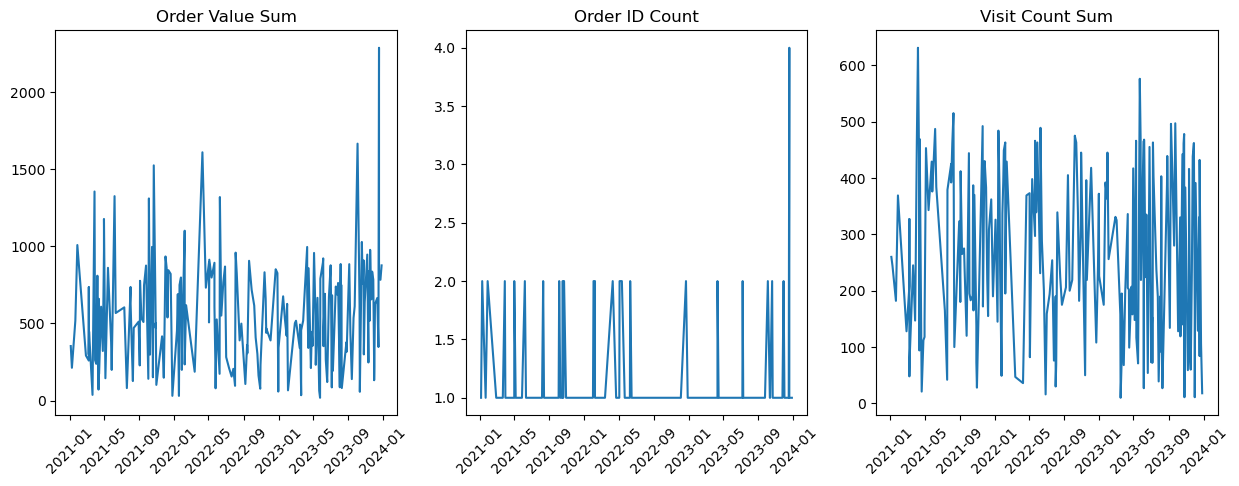

In [15]:
fig, axs = plt.subplots(ncols = 3,
                       nrows = 1, figsize = (15, 5))
axs[0].plot(sgm['Date'], sgm['OrderValue_sum'])                    
axs[1].plot(sgm['Date'], sgm['OrderID_count'])
axs[2].plot(sgm['Date'], sgm['VisitCount_sum'])

axs[0].set_title('Order Value Sum')
axs[1].set_title('Order ID Count')
axs[2].set_title('Visit Count Sum')

for ax in axs:
    ax.tick_params(axis='x', rotation=45)

It seems that we can work with this data. But this might have better look if we show it by month/year. Lets add month and year as new features in the dataframe.

In [16]:
sgm['Month'] = sgm['Date'].dt.month
sgm['Year'] = sgm['Date'].dt.year

sgm.head()

,StoreID,Date,OrderValue_sum,OrderID_count,VisitCount_sum,Month,Year
121,Store6,2021-01-05,353.23,1,260,1,2021
153,Store7,2021-01-09,212.31,2,244,1,2021
55,Store3,2021-01-21,517.84,1,182,1,2021
122,Store6,2021-01-28,1008.02,2,369,1,2021
123,Store6,2021-02-27,291.66,1,128,2,2021


Building graphs by month

In [21]:
filtered_sgm = sgm[sgm['Year'] == 2021]

monthly_data = filtered_sgm.groupby('Month').agg({
    'OrderValue_sum': 'sum',
    'OrderID_count': 'sum',
    'VisitCount_sum': 'sum'
}).reset_index()

monthly_data.head()

,Month,OrderValue_sum,OrderID_count,VisitCount_sum
0,1,2091.40,6,1055
1,2,291.66,1,128
2,3,3392.46,8,1297
3,4,2879.69,7,2213
4,5,3727.77,7,1862


Text(0.5, 1.0, 'Visit Count Sum')

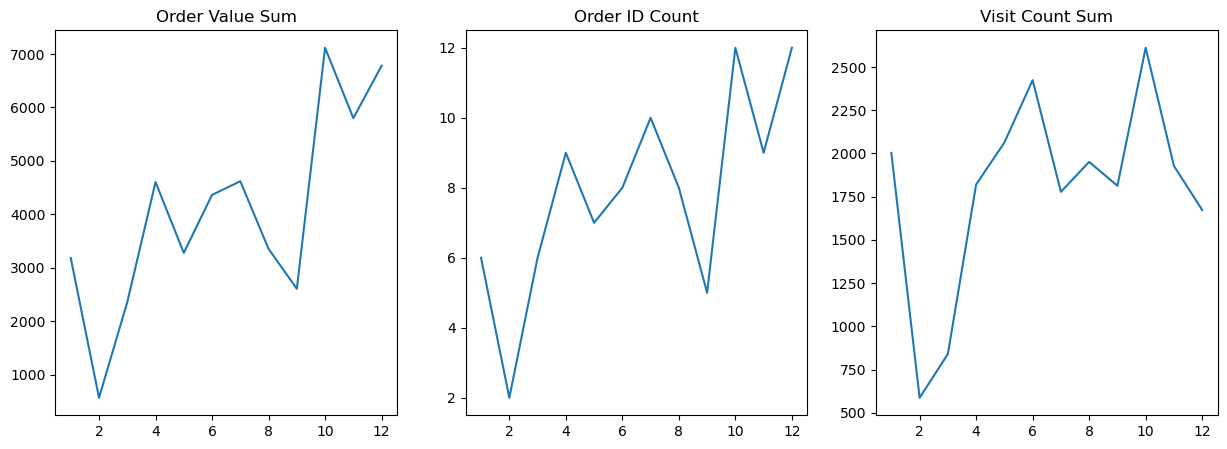

In [68]:
fig, axs = plt.subplots(ncols = 3,
                       nrows = 1, figsize = (15, 5))
axs[0].plot(monthly_data['Month'], monthly_data['OrderValue_sum'])                    
axs[1].plot(monthly_data['Month'], monthly_data['OrderID_count'])
axs[2].plot(monthly_data['Month'], monthly_data['VisitCount_sum'])

axs[0].set_title('Order Value Sum')
axs[1].set_title('Order ID Count')
axs[2].set_title('Visit Count Sum')

Now that everything seems reasonable, we can calculate the KPIs

 - Traffic = VisitsCount_sum
 - ConersionRate = OrderID_count / VisitsCount_sum * 100

In [85]:
monthly_data['ConversionRate'] = (monthly_data['OrderID_count'] / monthly_data['VisitCount_sum']) * 100

monthly_data.head()

,Month,OrderValue_sum,OrderID_count,VisitCount_sum,ConversionRate
0,1,3182.73,6,2003,0.299551
1,2,567.76,2,587,0.340716
2,3,2358.05,6,840,0.714286
3,4,4604.72,9,1820,0.494505
4,5,3278.63,7,2063,0.339312


In [86]:
monthly_data.describe()

,Month,OrderValue_sum,OrderID_count,VisitCount_sum,ConversionRate
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,6.500000,4053.144167,7.833333,1790.916667,0.450861
std,3.605551,1896.391310,2.886751,572.539869,0.150586
min,1.000000,567.760000,2.000000,587.000000,0.275786
25%,3.750000,3039.122500,6.000000,1751.750000,0.336992
50%,6.500000,3859.435000,8.000000,1874.000000,0.434820
75%,9.250000,4915.310000,9.250000,2018.000000,0.511487
max,12.000000,7117.520000,12.000000,2611.000000,0.717274


Plotting Conversion Rate:

Text(0.5, 1.0, 'Conversion Rate')

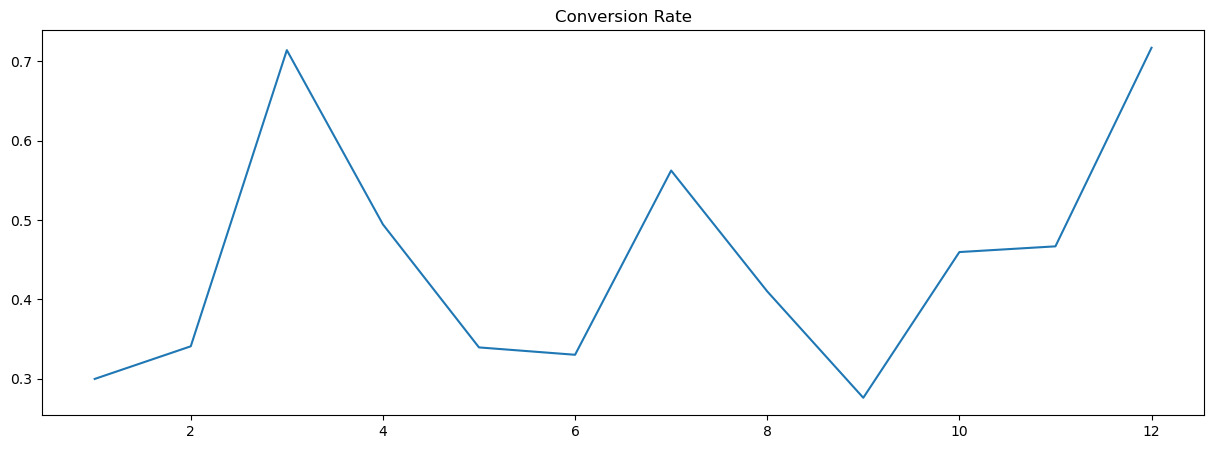

In [69]:
fig, ax = plt.subplots(ncols = 1,
                       nrows = 1, figsize = (15, 5))
ax.plot(monthly_data['Month'], monthly_data['ConversionRate'])                    

ax.set_title('Conversion Rate')

### Join Table Orders and Table Products to show Orders by Product

In [71]:
products = pd.read_csv('../data/Products_Table.csv')

In [72]:
orders_by_product = pd.merge(orders, products, on='ProductID', how='left')

orders_by_product.head()

,OrderID,StoreID,Date,ProductID,CustomerID,PromotionID,CampaignID,OrderValue,DiscountValue,Division,Category
0,Order1,Store4,2021-10-18,Product473,Customer1789,Promo4,Campaign3,237.71,114.56,Women,Accessories
1,Order2,Store8,2023-08-02,Product1,Customer4648,Promo1,Campaign6,761.24,94.64,Men,Hair Care
2,Order3,Store7,2022-01-06,Product416,Customer8822,Promo2,Campaign1,733.01,192.46,Men,Hair Care
3,Order4,Store8,2022-06-14,Product469,Customer7305,Promo4,Campaign10,840.82,180.34,Women,Make-up
4,Order5,Store1,2022-11-23,Product365,Customer559,Promo3,Campaign3,933.60,159.52,Women,Accessories


Lets do a quick check:

In [74]:
check_prod = products[products['ProductID'] == "Product1"]
check_prod

,ProductID,Division,Category
0,Product1,Men,Hair Care


This returns the same Division and Category as in the new generated dataframe orders_by_product  .